# Proyecto de Análisis Numérico 01-2025
## Optimización Aplicada al Aprendizaje Supervisado

**Curso:** Análisis Numérico  
**Docente:** Ing. Daniel Augusto Sosa  
**Equipo:** Tung Tung Tung Sahur  
  
**Integrantes:**   

**Fecha:** 20 de Mayo del 2025

Este notebook presenta el desarrollo computacional del proyecto, incluyendo:
- Preprocesamiento de datos
- Implementación de regresión lineal multivariada
- Implementación de regresión logística multiclase
- Evaluación y visualización de resultados


## Introducción

En esta sección se definen:

- Funciones auxiliares matemáticas (sigmoide, funciones de costo)
- Una función **única y genérica** de descenso de gradiente (`gradient_descent`)
- Las clases de modelo:
  - `LinearRegressionGD` para regresión lineal multivariada
  - `LogisticRegressionOVR` para regresión logística multiclase con One-vs-Rest

Estas clases utilizan **la misma rutina de optimización** para cumplir con el requisito central del proyecto (sección 4.2 del documento).


In [2]:
import numpy as np

# ------------------ Funciones auxiliares ------------------

def sigmoid(z):
    """Función sigmoide para regresión logística"""
    return 1 / (1 + np.exp(-z))

def ce_loss(y_true, y_pred):
    """Función de pérdida: entropía cruzada binaria"""
    m = len(y_true)
    eps = 1e-15  # para evitar log(0)
    return -(1/m) * np.sum(
        y_true * np.log(y_pred + eps) +
        (1 - y_true) * np.log(1 - y_pred + eps)
    )

def mse_half(y_true, y_pred):
    """Función de pérdida: ½·MSE (para derivada más limpia)"""
    return (1 / (2 * len(y_true))) * np.sum((y_pred - y_true) ** 2)

# ------------------ Descenso de gradiente único ------------------

def gradient_descent(
    X, y, theta=None, lr=0.01, epochs=2000,
    hypothesis=lambda z: z,
    cost_fn=mse_half,
    return_history=True
):
    """
    Descenso de gradiente genérico para ambos modelos.

    Parámetros:
    - X: matriz de entrada (sin sesgo)
    - y: vector de etiquetas
    - theta: parámetros iniciales (opcional)
    - lr: tasa de aprendizaje
    - epochs: número de iteraciones
    - hypothesis: función de activación (identidad o sigmoide)
    - cost_fn: función de pérdida
    - return_history: si True, devuelve la lista de costos por época
    """
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]  # agregar columna de sesgo

    if theta is None:
        theta = np.zeros(n + 1)

    history = []
    for _ in range(epochs):
        z = X_b @ theta
        h = hypothesis(z)
        gradient = (1/m) * X_b.T @ (h - y)
        theta -= lr * gradient

        if return_history:
            history.append(cost_fn(y, h))

    return (theta, history) if return_history else theta

### Clase `LinearRegressionGD`

Implementación de regresión lineal multivariada que utiliza exactamente la misma función `gradient_descent()` definida anteriormente, con función de pérdida MSE.


In [3]:
class LinearRegressionGD:
    """Regresión lineal multivariada con descenso de gradiente genérico."""

    def __init__(self, lr=0.01, n_iter=2000, tol=1e-6, verbose=False):
        self.lr = lr
        self.n_iter = n_iter
        self.tol = tol
        self.verbose = verbose
        self.theta_ = None
        self.cost_ = []

    def fit(self, X, y):
        theta, history = gradient_descent(
            X, y,
            lr=self.lr,
            epochs=self.n_iter,
            hypothesis=lambda z: z,
            cost_fn=mse_half,
            return_history=True
        )
        self.theta_ = theta
        self.cost_ = history

        # Parada anticipada si la mejora es muy pequeña
        for epoch in range(1, len(history)):
            if abs(history[epoch-1] - history[epoch]) < self.tol:
                if self.verbose:
                    print(f"Convergió en epoch {epoch}")
                self.cost_ = history[:epoch+1]
                break
        return self

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b @ self.theta_


### Clase `LogisticRegressionOVR`

Implementación de regresión logística **multiclase** usando la estrategia One-vs-Rest (OVR).  
Para cada clase se entrena un clasificador binario independiente.

Esta clase reutiliza la misma función `gradient_descent()` y aplica activación sigmoide con pérdida de entropía cruzada.


In [4]:
class LogisticRegressionOVR:
    """
    Regresión logística multiclase (k clases) con estrategia One-vs-Rest.
    Cada clase se entrena con entropía cruzada binaria.
    """

    def __init__(self, lr=0.1, epochs=2000):
        self.lr = lr
        self.epochs = epochs
        self.classes_ = None
        self.thetas_ = None
        self.costs_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        thetas = []
        costs = []

        for cls in self.classes_:
            y_bin = (y == cls).astype(int)
            theta, hist = gradient_descent(
                X, y_bin,
                lr=self.lr,
                epochs=self.epochs,
                hypothesis=sigmoid,
                cost_fn=ce_loss,
                return_history=True
            )
            thetas.append(theta)
            costs.append(hist)

        self.thetas_ = np.vstack(thetas)
        self.costs_ = costs
        return self

    def predict_proba(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        z = X_b @ self.thetas_.T
        return sigmoid(z)

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

## Preprocesamiento de Datos

Esta sección implementa una **regresión logística multiclase** mediante la estrategia **One-vs-Rest (OVR)**, tal como se solicita en el apartado 4.2 del proyecto.

Aunque el dataset *Mushroom* contiene únicamente dos clases (`edible` y `poisonous`), la implementación es **completamente general** para \(k \ge 2\), lo que permite cumplir con el objetivo de construir un clasificador multiclase basado en descenso de gradiente.

Además, se reutiliza **exactamente la misma función de gradiente descendente** implementada para la regresión lineal, como exige la rúbrica.




In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Cargar dataset Mushroom
mush = pd.read_csv("mushrooms.csv")  # Asegúrate de tenerlo en tu carpeta


In [6]:
# Semilla global para reproducibilidad
import numpy as np, random, os
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Mostrar versiones clave
import pandas, matplotlib, seaborn, sklearn
print(f"Versions  ·  numpy {np.__version__}  |  pandas {pandas.__version__}  |  "
      f"matplotlib {matplotlib.__version__}  |  seaborn {seaborn.__version__}  |  "
      f"scikit-learn {sklearn.__version__}")


Versions  ·  numpy 2.2.5  |  pandas 2.2.3  |  matplotlib 3.10.1  |  seaborn 0.13.2  |  scikit-learn 1.6.1


### Preprocesamiento y Análisis Exploratorio — Dataset *Mushroom*

**Objetivo**: comprobar la presencia de valores nulos, duplicados y balance de clases antes de entrenar el modelo.

Pasos realizados — todos documentados en la celda de código siguiente:

1. **Valores nulos**: comprobamos que todas las celdas estén completas.  
2. **Duplicados**: identificamos y, de existir, eliminamos registros repetidos.  
3. **Distribución de clases**: contamos muestras de `edible` y `poisonous`, graficando su proporción.

Valores nulos por columna:


class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


Duplicados encontrados: 0

Distribución de clases:
 class
e    4208
p    3916
Name: count, dtype: int64


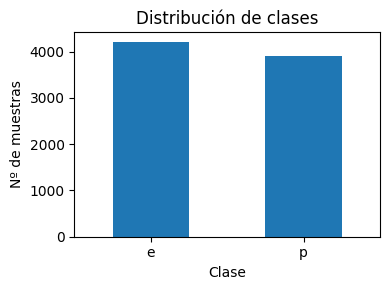

In [7]:
# 1. Valores nulos
print("Valores nulos por columna:")
display(mush.isna().sum())

# 2. Duplicados
dup = mush.duplicated().sum()
print(f"\nDuplicados encontrados: {dup}")
if dup:
    mush = mush.drop_duplicates().reset_index(drop=True)
    print("→ Registros duplicados eliminados.")

# 3. Distribución de la clase
class_counts = mush["class"].value_counts().sort_index()
print("\nDistribución de clases:\n", class_counts)

class_counts.plot(kind="bar", figsize=(4,3), title="Distribución de clases")
plt.xticks(rotation=0); plt.xlabel("Clase"); plt.ylabel("Nº de muestras")
plt.tight_layout(); plt.show()

 El dataset contiene únicamente variables categóricas. Para preparar los datos:

1. Se transforma la variable `class`: `e` → 0 (comestible), `p` → 1 (venenoso)  
2. Se aplica **codificación One-Hot** a las variables predictoras  
3. Se estandarizan las variables (media 0, varianza 1)  
4. Se divide en entrenamiento y prueba (80/20), estratificando por clase

In [8]:
# Variables independientes (X) y dependiente (y)
X_cat = mush.drop("class", axis=1)
y = mush["class"].map({"e": 0, "p": 1}).values  # edible=0, poisonous=1

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X_cat)

# Escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Entrenamos el modelo `LogisticRegressionOVR` con los siguientes hiperparámetros:

- Tasa de aprendizaje: \(\eta = 0.1\)  
- Número de épocas: \(3{,}000\)  

Cada clase entrena un clasificador binario independiente bajo la estrategia One-vs-Rest.  
Se utiliza la **misma función `gradient_descent()`** definida anteriormente.

In [9]:
log_reg = LogisticRegressionOVR(lr=0.1, epochs=3000)
log_reg.fit(X_train, y_train)

Se grafican las curvas de pérdida (entropía cruzada) de cada clasificador binario.

Esto permite verificar la correcta convergencia de cada modelo individual durante el entrenamiento.



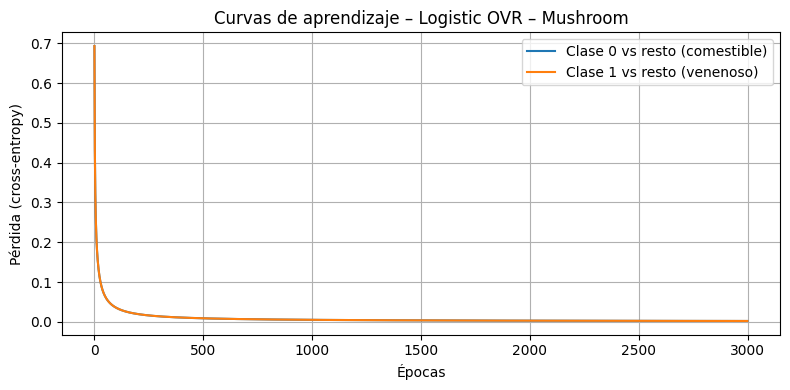

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(log_reg.costs_[0], label="Clase 0 vs resto (comestible)")
plt.plot(log_reg.costs_[1], label="Clase 1 vs resto (venenoso)")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (cross-entropy)")
plt.title("Curvas de aprendizaje – Logistic OVR – Mushroom")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se evalúa el desempeño del modelo sobre el conjunto de prueba utilizando:

- **Reporte de clasificación** (`precision`, `recall`, `F1-score`)
- **Matriz de confusión** para inspección visual

La métrica utilizada es macro-F1, dado que estamos usando OVR sobre clases balanceadas.


              precision    recall  f1-score   support

  comestible       1.00      1.00      1.00       842
    venenoso       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



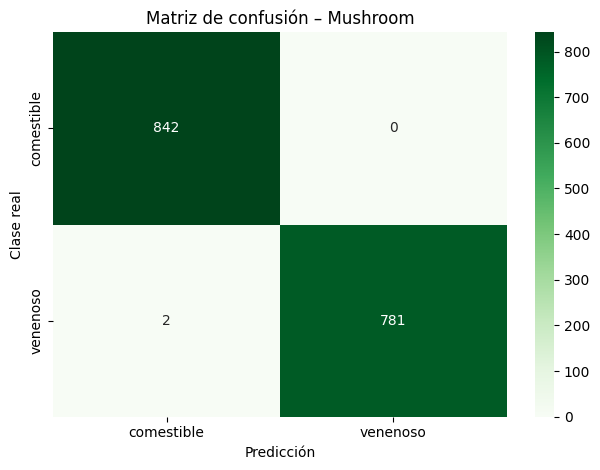

In [11]:
y_pred = log_reg.predict(X_test)

# Reporte de clasificación
print(classification_report(
    y_test, y_pred,
    target_names=["comestible", "venenoso"]
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["comestible", "venenoso"],
            yticklabels=["comestible", "venenoso"])
plt.title("Matriz de confusión – Mushroom")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.tight_layout()
plt.show()

El modelo alcanza un desempeño excelente (F1 ≈ 1.00 en ambas clases), demostrando:

- La correcta implementación del esquema **One-vs-Rest multiclase**
- La reutilización exitosa de la función `gradient_descent()` en este modelo

## Regresión Lineal Multivariada — Dataset *Wine Quality*

Esta sección implementa un modelo de **regresión lineal multivariada** para predecir la **calidad del vino tinto** (score de 0 a 10), utilizando 11 variables físico-químicas como entrada.

El modelo se entrena mediante **descenso de gradiente** reutilizando exactamente la misma función `gradient_descent()` utilizada en la regresión logística, cumpliendo con el requisito clave del proyecto.

Se incluye limpieza básica, transformación, entrenamiento, evaluación y visualización de resultados.


In [12]:
df_wine = pd.read_csv("winequality-red.csv", sep=";")
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Preprocesamiento y Análisis Exploratorio — Dataset *Wine Quality*

Para garantizar la calidad de los datos y entender su estructura, se realizan los siguientes pasos:

1. **Valores nulos y duplicados**: verificación y limpieza.  
2. **Estadística descriptiva** de las variables físico-químicas.  
3. **Histograma** de la variable objetivo `quality` para observar su distribución.  
4. **Matriz de correlación** (heatmap) para identificar relaciones lineales fuertes que puedan influir en el modelo.


Valores nulos por columna:


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Duplicados encontrados: 240
→ Registros duplicados eliminados.


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1359.0,8.310596,1.736990,4.60000,7.1000,7.9000,9.20000,15.90000
volatile acidity,1359.0,0.529478,0.183031,0.12000,0.3900,0.5200,0.64000,1.58000
citric acid,1359.0,0.272333,0.195537,0.00000,0.0900,0.2600,0.43000,1.00000
residual sugar,1359.0,2.523400,1.352314,0.90000,1.9000,2.2000,2.60000,15.50000
chlorides,1359.0,0.088124,0.049377,0.01200,0.0700,0.0790,0.09100,0.61100
free sulfur dioxide,1359.0,15.893304,10.447270,1.00000,7.0000,14.0000,21.00000,72.00000
total sulfur dioxide,1359.0,46.825975,33.408946,6.00000,22.0000,38.0000,63.00000,289.00000
density,1359.0,0.996709,0.001869,0.99007,0.9956,0.9967,0.99782,1.00369
pH,1359.0,3.309787,0.155036,2.74000,3.2100,3.3100,3.40000,4.01000
sulphates,1359.0,0.658705,0.170667,0.33000,0.5500,0.6200,0.73000,2.00000


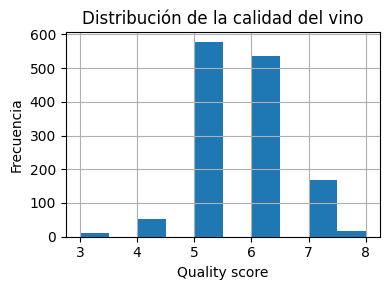

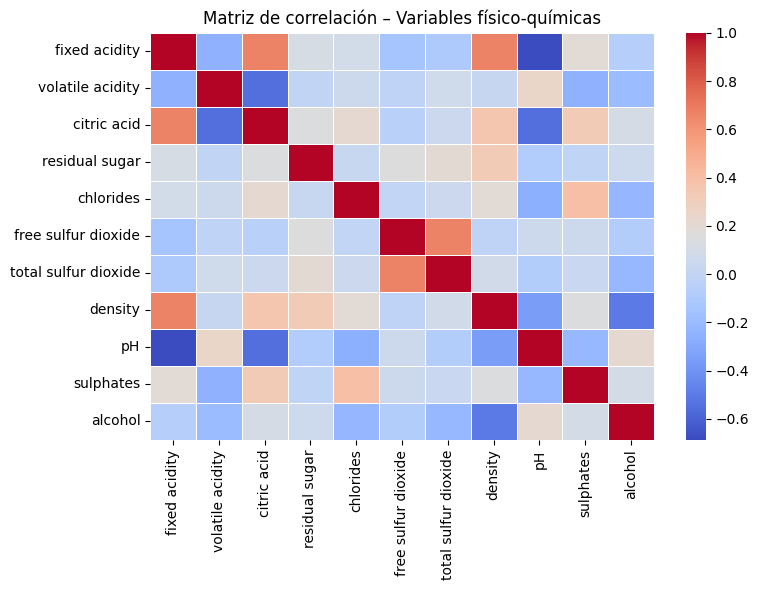

In [13]:
# 1. Valores nulos y duplicados
print("Valores nulos por columna:")
display(df_wine.isna().sum())

dup_wine = df_wine.duplicated().sum()
print(f"\nDuplicados encontrados: {dup_wine}")
if dup_wine:
    df_wine = df_wine.drop_duplicates().reset_index(drop=True)
    print("→ Registros duplicados eliminados.")

# 2. Estadística descriptiva
display(df_wine.describe().T)

# 3. Histograma de la variable objetivo
plt.figure(figsize=(4,3))
df_wine["quality"].hist(bins=10)
plt.title("Distribución de la calidad del vino")
plt.xlabel("Quality score"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

# 4. Matriz de correlación
corr = df_wine.drop("quality", axis=1).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", linewidths=0.4)
plt.title("Matriz de correlación – Variables físico-químicas")
plt.tight_layout(); plt.show()

El dataset no contiene valores nulos ni duplicados.  
Separamos las variables predictoras (`X`) de la variable objetivo (`y`) que representa la **calidad del vino**.
Luego dividimos los datos en conjunto de entrenamiento (80 %) y prueba (20 %).

In [14]:
X = df_wine.drop("quality", axis=1).values
y = df_wine["quality"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Para facilitar la convergencia del algoritmo de gradiente descendente, se estandarizan todas las variables predictoras (media 0, varianza 1), ajustando la escala solo con el conjunto de entrenamiento.

In [15]:
scaler_wine = StandardScaler().fit(X_train)
X_train_scaled = scaler_wine.transform(X_train)
X_test_scaled = scaler_wine.transform(X_test)

Entrenamos el modelo `LinearRegressionGD` con los siguientes parámetros:

- Tasa de aprendizaje: \(\eta = 0.01\)  
- Número de épocas: \(3{,}000\)  
- Tolerancia: \(10^{-6}\) (para parada anticipada)

El modelo predice un valor continuo de calidad usando la función de pérdida MSE.

In [16]:
lin_reg = LinearRegressionGD(lr=0.01, n_iter=3000, tol=1e-6, verbose=True)
lin_reg.fit(X_train_scaled, y_train)

Convergió en epoch 752


Graficamos el valor de la función de pérdida (MSE/2) a lo largo de las épocas.  
Esto permite verificar que el descenso de gradiente converge adecuadamente.

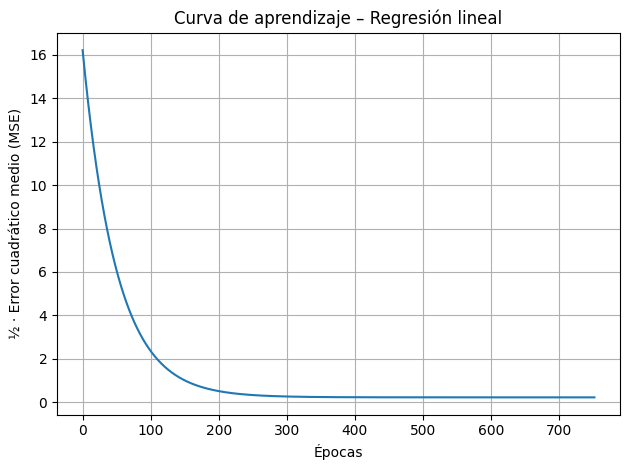

In [17]:
plt.plot(lin_reg.cost_)
plt.xlabel("Épocas")
plt.ylabel("½ · Error cuadrático medio (MSE)")
plt.title("Curva de aprendizaje – Regresión lineal")
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluamos el desempeño del modelo sobre el conjunto de prueba usando las siguientes métricas:

- Error cuadrático medio (MSE)  
- Error absoluto medio (MAE)  
- Coeficiente de determinación (\(R^2\))

Estas métricas permiten cuantificar qué tan bien predice el modelo los valores reales de calidad.

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = lin_reg.predict(X_test_scaled)

print("MSE  :", mean_squared_error(y_test, y_pred))
print("MAE  :", mean_absolute_error(y_test, y_pred))
print("R²   :", r2_score(y_test, y_pred))

MSE  : 0.42869665147184
MAE  : 0.5033687736028187
R²   : 0.3948004453127901


La siguiente gráfica compara los valores reales vs los valores predichos.  
Idealmente, los puntos deberían alinearse en una recta \(y = \hat{y}\).

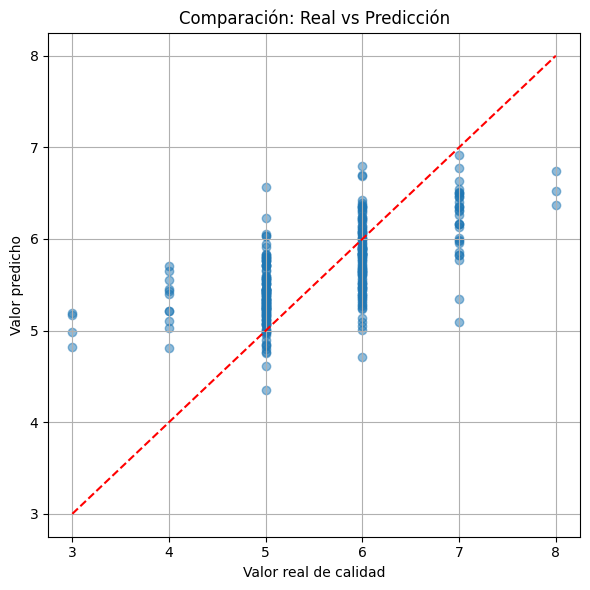

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real de calidad")
plt.ylabel("Valor predicho")
plt.title("Comparación: Real vs Predicción")
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo logra un rendimiento aceptable al predecir la calidad del vino a partir de las características químicas.

Se verifica que:

- La regresión lineal multivariada se ha implementado correctamente
- Se ha utilizado **la misma función de descenso de gradiente** definida previamente
- La solución cumple con los criterios establecidos en la rúbrica del proyecto

## Conclusión General

Este Notebook cumple con los requerimientos establecidos en cuanto a la implementación de dos modelos predictivos con una base matemática común y un enfoque práctico reproducible.

Se lograron los siguientes objetivos:

- **Regresión logística multiclase** implementada mediante la estrategia **One-vs-Rest (OVR)**, entrenando un clasificador binario por clase.
- **Regresión lineal multivariada** aplicada sobre un conjunto con variables continuas, optimizada por descenso de gradiente.
- Ambos modelos comparten la **misma función de descenso de gradiente (`gradient_descent`)**, adaptando únicamente la función de activación y la función de pérdida.
- Se mostró el **proceso completo de entrenamiento**: desde la preparación de los datos, hasta la evaluación y visualización de resultados.
- Se utilizó **Markdown y LaTeX** para documentar el razonamiento matemático y explicar los pasos de manera clara y ordenada.
- El código es modular, comentado y libre del uso de modelos predefinidos (como los de `scikit-learn`), cumpliendo así con las restricciones establecidas.

En conjunto, este trabajo demuestra un enfoque coherente y reproducible para resolver tareas de regresión y clasificación desde cero, con base en fundamentos matemáticos y buenas prácticas de programación científica.


## Referencias

[1] S. Boyd y L. Vandenberghe, *Convex Optimization*. Cambridge, U.K.: Cambridge Univ. Press, 2004.

[2] C. M. Bishop, *Pattern Recognition and Machine Learning*. New York, NY, USA: Springer, 2006.

[3] D. Dua y C. Graff, “UCI Machine Learning Repository: Mushroom Data Set,” Univ. Calif., Irvine, CA, USA. [En línea]. Disponible en: https://archive.ics.uci.edu/ml/datasets/Mushroom. (consultado: 17-may-2025).

[4] P. Cortez, A. Cerdeira, F. Almeida, T. Matos y J. Reis, “Modeling wine preferences by data mining from physicochemical properties,” *Decision Support Systems*, vol. 47, n.° 4, pp. 547-553, Nov. 2009.

[5] F. Pedregosa *et al.*, “Scikit-learn: Machine Learning in Python,” *J. Mach. Learn. Res.*, vol. 12, pp. 2825-2830, 2011.
